# A2 Module 1: PET-CT Image reconstruction

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage as ski
import time
from skimage.transform import radon, iradon, iradon_sart, rescale, resize
import cv2

You are given control of a PET-CT scanner, as the computer that does the reconstruction is broken. We have some patient that was scanned in the machine, and we need the to give the reconstructions to the doctors, its your job to clean up the data (sinograms) and produce reconstructions.

The following code will load and display the measured sinograms.

In [2]:
ct_sino=np.load("ct_sinogram.npy")
pet_sino=np.load("pet_sinogram.npy")


The CT sinogram is exactly what has been measured, with no data changing. Lucky you! All CT scanners in the world are fan-beam geometry, but this one is the only one that is parallel beam (i.e. X-ray source is a line parallel to the detector). This is only important because you can now use radon and iradon from skimage, which you would not be able to use if it was fan-beam shaped. It has been acquired around 180 degrees, one measurement per degree.

The PET sinogram has been minimally processed. In particular, the listmode data has been made into a singoram for you, and the singles/random events and the background noise have been corrected, so they are not present in the singorams. It has been binned to 180 degrees, on 100 different angles.

Text(0.5, 1.0, 'CT Sinogram')

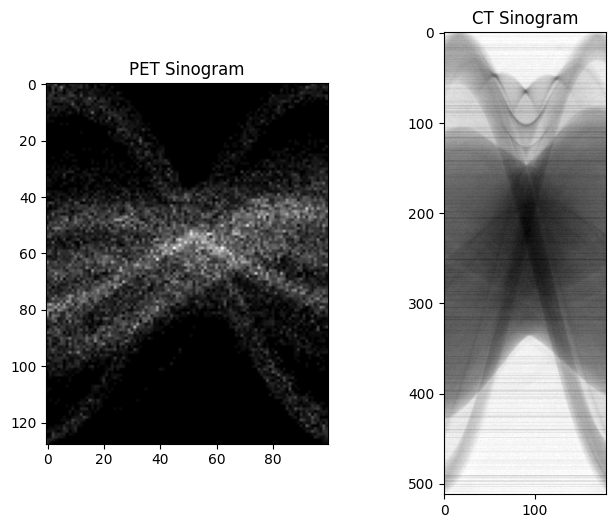

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(8, 6))
ax[0].imshow(pet_sino, cmap="gray")
ax[0].set_title("PET Sinogram")
ax[1].imshow(ct_sino, cmap="gray")
ax[1].set_title("CT Sinogram")

### Exercise 1.1: Clean up sinograms

Text(0.5, 1.0, 'CLeaned CT Sinogram')

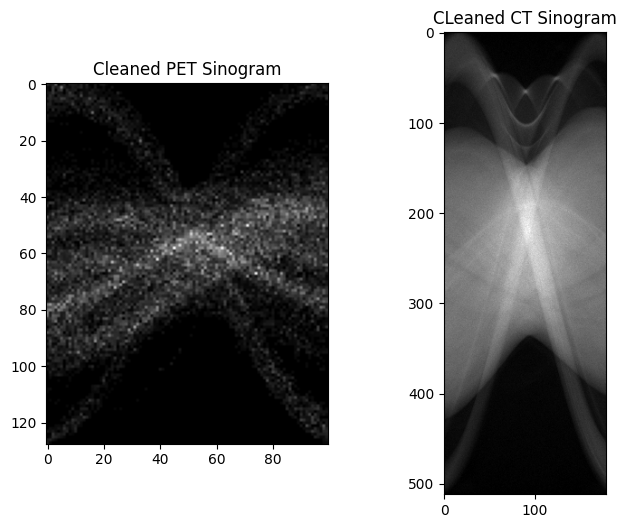

In [4]:
### CT SCAN 

dark = np.load("ct_dark.npy")
flat = np.load("ct_flat.npy")

M = 1 

clean_ct = -np.log ( M * ((ct_sino - dark) / (flat - dark)) )

### PET SCAN
pet_calib = np.load("pet_calibration.npy")
clean_pet = pet_sino / pet_calib

# Display
fig, ax = plt.subplots(1, 2, figsize=(8, 6))
ax[0].imshow(clean_pet, cmap="gray")
ax[0].set_title("Cleaned PET Sinogram")
ax[1].imshow(clean_ct, cmap="gray")
ax[1].set_title("CLeaned CT Sinogram")

### Exercise 1.2: FBP and OS-SART

First, I will try to do FBP

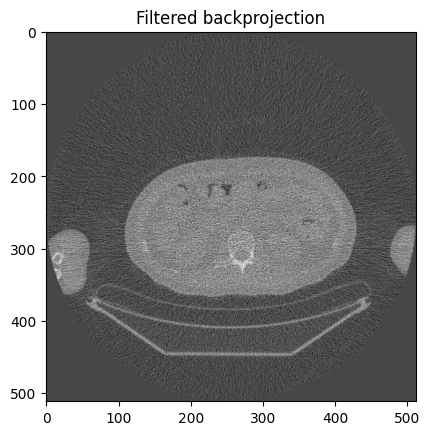

In [5]:
### FBP

theta = np.linspace(0., 180., 180, endpoint=False)
recon_ct = iradon(clean_ct, theta=theta, filter_name="ramp")
plt.title("Filtered backprojection")
plt.imshow(recon_ct,cmap="gray")

#### Notes/sources on reconstruction information: #####
    #theta describes the angles (in degrees) at which the projections were taken
    #(http://www.ece.northwestern.edu/local-apps/matlabhelp/toolbox/images/iradon.html#:~:text=iradon%20assumes%20that%20the%20center,which%20the%20projections%20were%20taken.)
    #Parallel beam acquired around 180 degrees, one measurement per degree
    # why FBP has negative values: https://stackoverflow.com/questions/45606507/why-iradon-returns-negative-pixel-values#:~:text=Yes%2C%20the%20FBP%20(filtered%20back,just%20crop%20those%20values%20generally.

Now I will test how OS-SART looks. To do this, I will plot three different OS-SART, each with a different Gamma value for 5 iterations to tune which one is the best. 

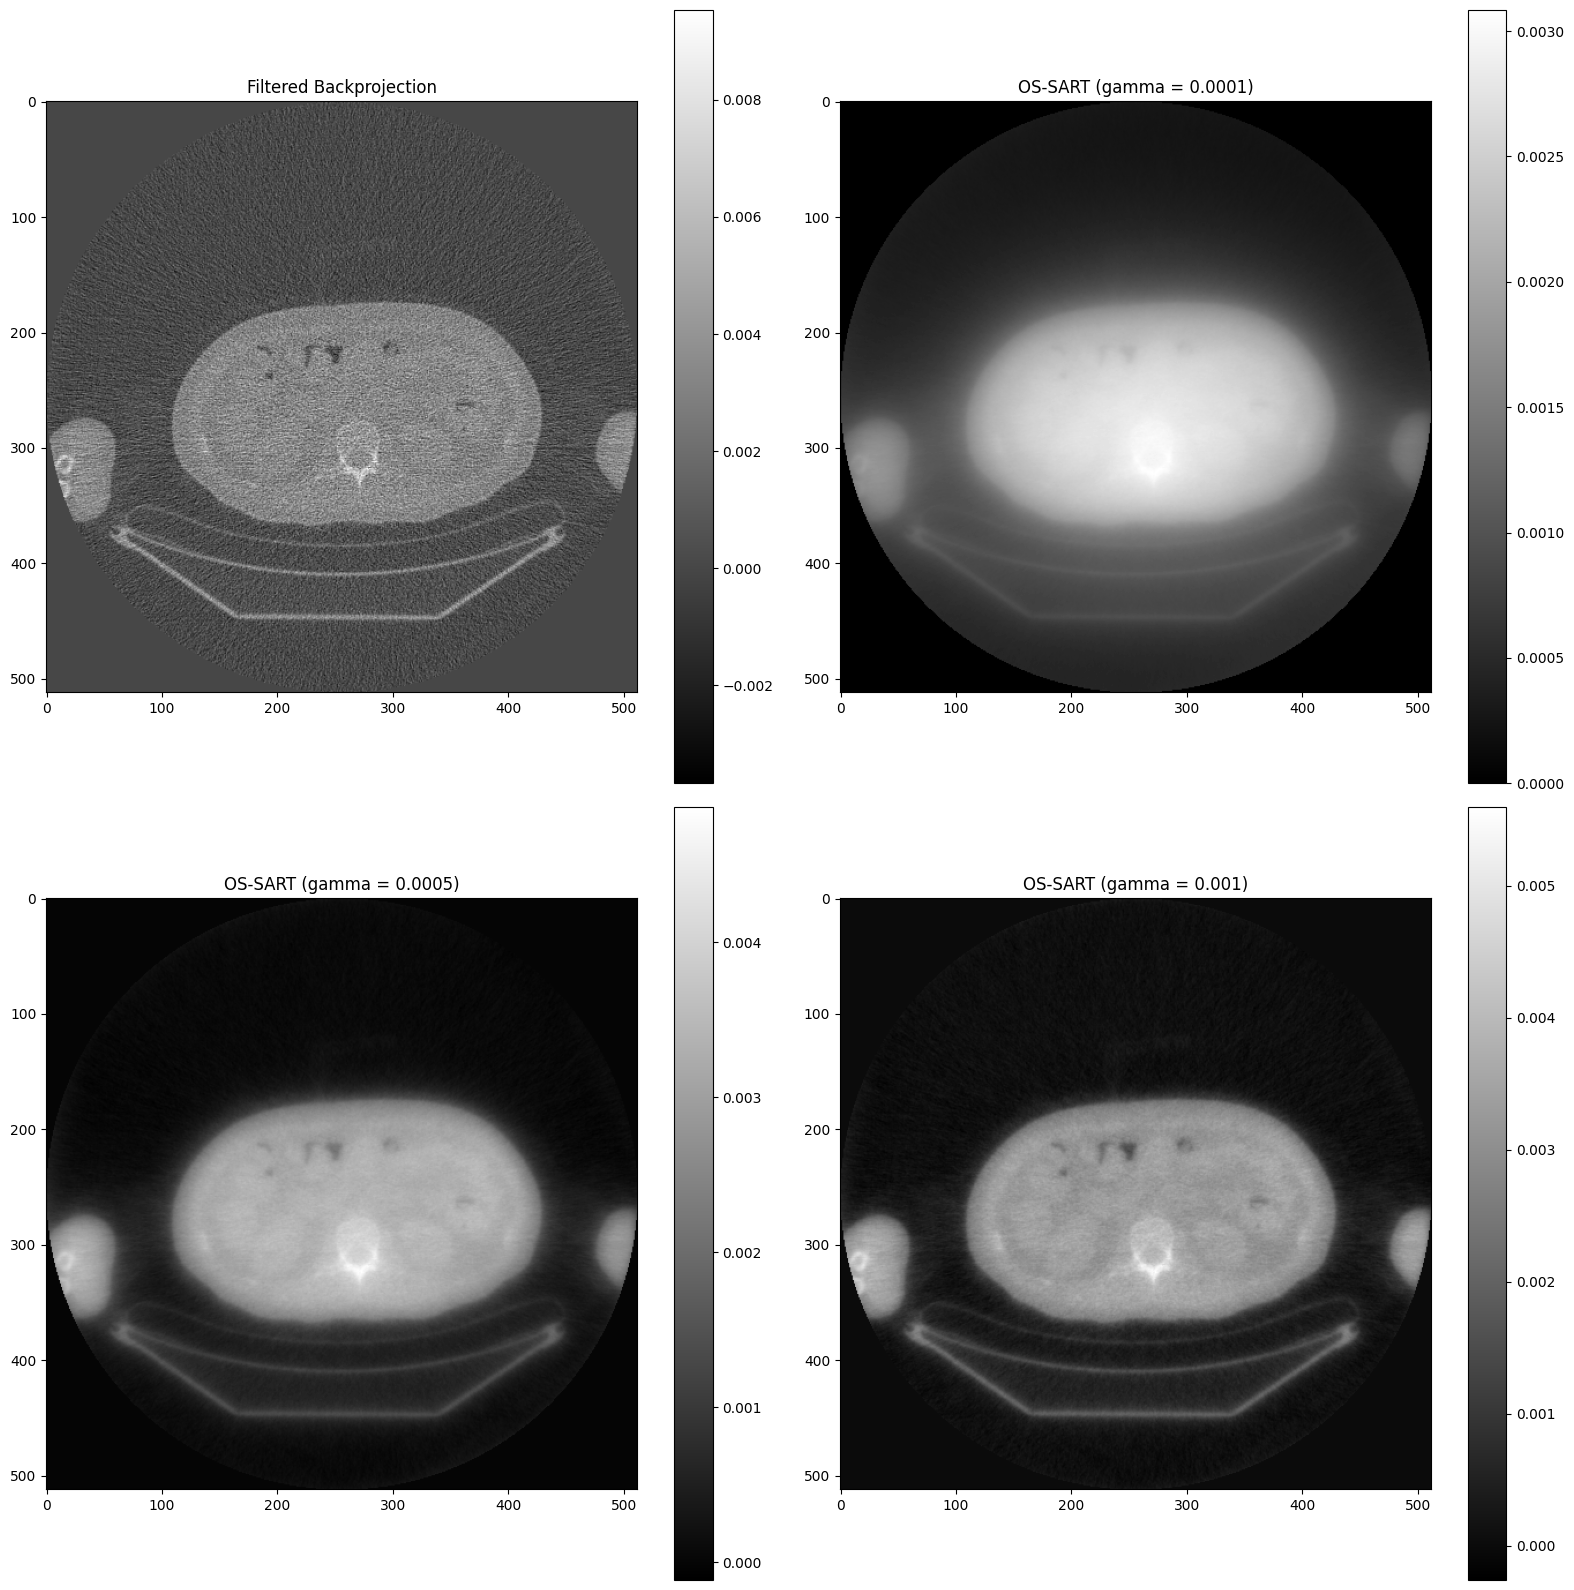

In [6]:

n_subsets = 10
subset_As = np.array_split(np.arange(len(theta)), n_subsets)  # This outputs 10 arrays, each with 18 elements. eg. [0...17][18...35]...[162...179]

gamma = [-0.0001, -0.0005, -0.001]  # (learning rate) to be changed
max_iter = 5  # (number of iterations) to be changed

# Initialize reconstructed image (x^k)
recon1 = np.zeros((clean_ct.shape[0], clean_ct.shape[0]))
recon2 = np.zeros((clean_ct.shape[0], clean_ct.shape[0]))
recon3 = np.zeros((clean_ct.shape[0], clean_ct.shape[0]))

for index, gamma_value in enumerate(gamma):
    image = np.zeros((clean_ct.shape[0], clean_ct.shape[0]))
    for k in range(max_iter):
        for subset in subset_As:
            # Forward project image into sino (A_i * x^k), certain projections multiplied by current reconstructed image
            theta_subset = theta[subset]
            estimated_sinogram = radon(image, theta=theta_subset, circle=True)  

            # Sinogram errors (A_i * x^k - b)
            sinogram_error = estimated_sinogram - clean_ct[:, subset]

            # Error between the blank image and the real image (multiplied by A^T_i)
            backprojected_error = iradon(sinogram_error, theta=theta_subset, filter_name=None, circle=True)  

            # Update step
            update = gamma_value * backprojected_error  # Apply OS-SART update rule
            image += update  # Update reconstructed image

    if index == 0:
        recon1 = image
    elif index == 1:
        recon2 = image
    elif index == 2:
        recon3 = image

# Plotting against FBP
fig, ax = plt.subplots(2, 2, figsize=(16, 16))

im1 = ax[0, 0].imshow(recon_ct, cmap='gray')  #FBP
ax[0, 0].set_title('Filtered Backprojection',fontsize=12)
fig.colorbar(im1, ax=ax[0, 0])

im2 = ax[0, 1].imshow(recon1, cmap='gray')  
ax[0, 1].set_title('OS-SART (gamma = 0.0001)',fontsize=12)
fig.colorbar(im2, ax=ax[0, 1])


im3 = ax[1, 0].imshow(recon2, cmap='gray')  
ax[1, 0].set_title('OS-SART (gamma = 0.0005)',fontsize=12)
fig.colorbar(im3, ax=ax[1, 0])

im4 = ax[1, 1].imshow(recon3, cmap='gray')  
ax[1, 1].set_title('OS-SART (gamma = 0.001)',fontsize=12)
fig.colorbar(im4, ax=ax[1, 1])

plt.tight_layout()
plt.show()


Findings: gamma 0.005 and 0.01 failed to converge. 0.0001, 0.0005, and 0.001 worked well, with 0.001 working the best.

Next steps: Fixing gamma = 0.001, I will try max iteration = 10, 30  and 50

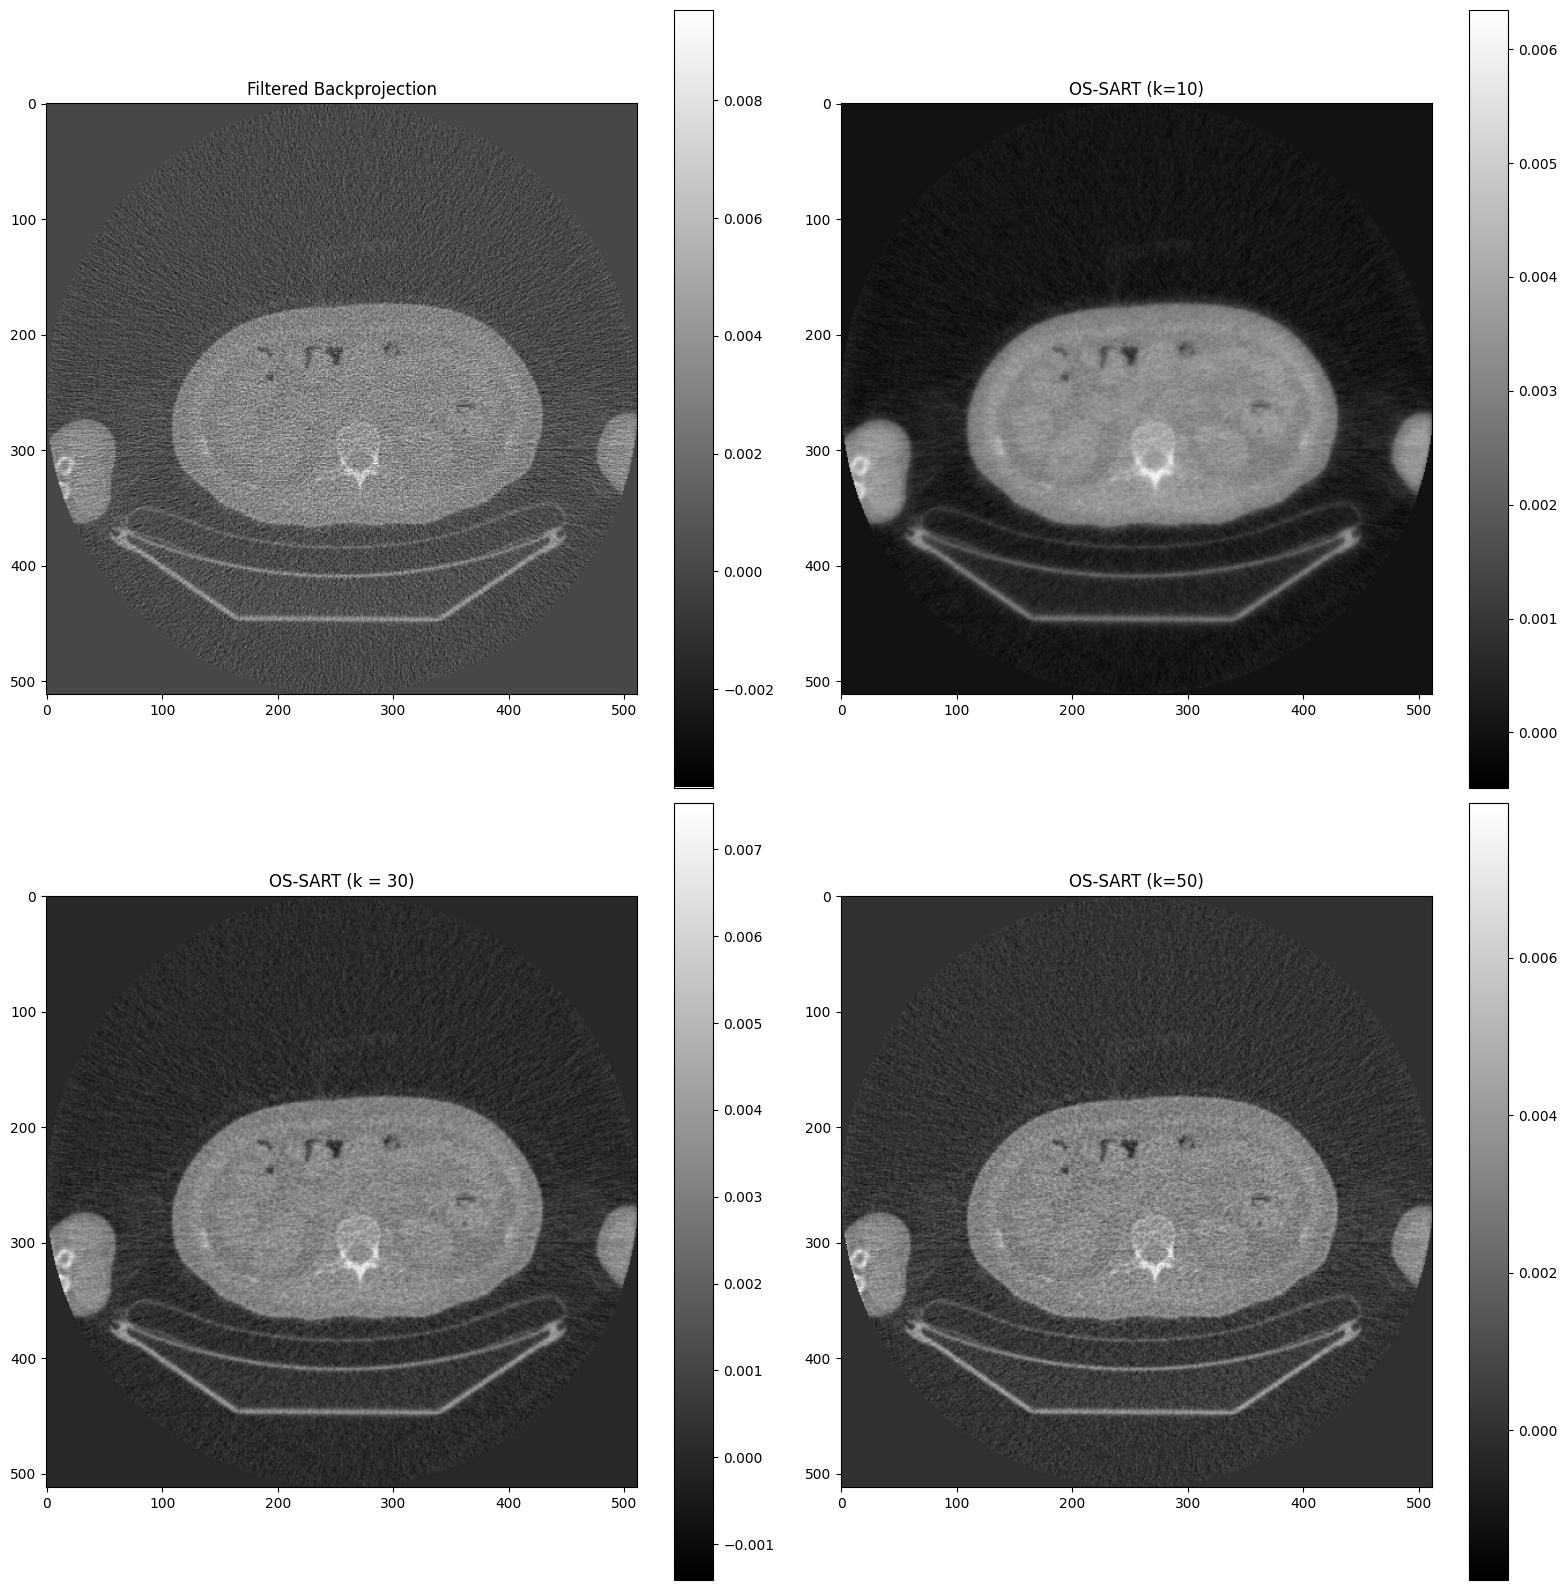

In [7]:

n_subsets = 10
subset_As = np.array_split(np.arange(len(theta)), n_subsets) 

gamma = -0.001
max_iter = [10, 30, 50] 

# Initialize reconstructed image (x^k)
recon1 = np.zeros((clean_ct.shape[0], clean_ct.shape[0]))
recon2 = np.zeros((clean_ct.shape[0], clean_ct.shape[0]))
recon3 = np.zeros((clean_ct.shape[0], clean_ct.shape[0]))

for index, iteration in enumerate(max_iter):
    image = np.zeros((clean_ct.shape[0], clean_ct.shape[0]))
    for k in range(iteration):
        for subset in subset_As:
            # Forward project image into sino (A_i * x^k), certain projections multiplied by current reconstructed image
            theta_subset = theta[subset]
            estimated_sinogram = radon(image, theta=theta_subset, circle=True)  

            # Sinogram errors (A_i * x^k - b)
            sinogram_error = estimated_sinogram - clean_ct[:, subset]

            # Error between the blank image and the real image (multiplied by A^T_i)
            backprojected_error = iradon(sinogram_error, theta=theta_subset, filter_name=None, circle=True)  

            # Update step
            update = gamma * backprojected_error  # Apply OS-SART update rule
            image += update  # Update reconstructed image

    if index == 0:
        recon1 = image
    elif index == 1:
        recon2 = image
    elif index == 2:
        recon3 = image

# Plotting against FBP
fig, ax = plt.subplots(2, 2, figsize=(16, 16))

im1 = ax[0, 0].imshow(recon_ct, cmap='gray') 
ax[0, 0].set_title('Filtered Backprojection',fontsize=12)
fig.colorbar(im1, ax=ax[0, 0])

im2 = ax[0, 1].imshow(recon1, cmap='gray')  
ax[0, 1].set_title('OS-SART (k=10)',fontsize=12)
fig.colorbar(im2, ax=ax[0, 1])

im3 = ax[1, 0].imshow(recon2, cmap='gray')  
ax[1, 0].set_title('OS-SART (k = 30)',fontsize=12)
fig.colorbar(im3, ax=ax[1, 0])

im4 = ax[1, 1].imshow(recon3, cmap='gray')  
ax[1, 1].set_title('OS-SART (k=50)',fontsize=12)
fig.colorbar(im4, ax=ax[1, 1])

plt.tight_layout()
plt.show()



Findings: The best gamma value is 0.001, and the best k value is 30. I will replot these below:

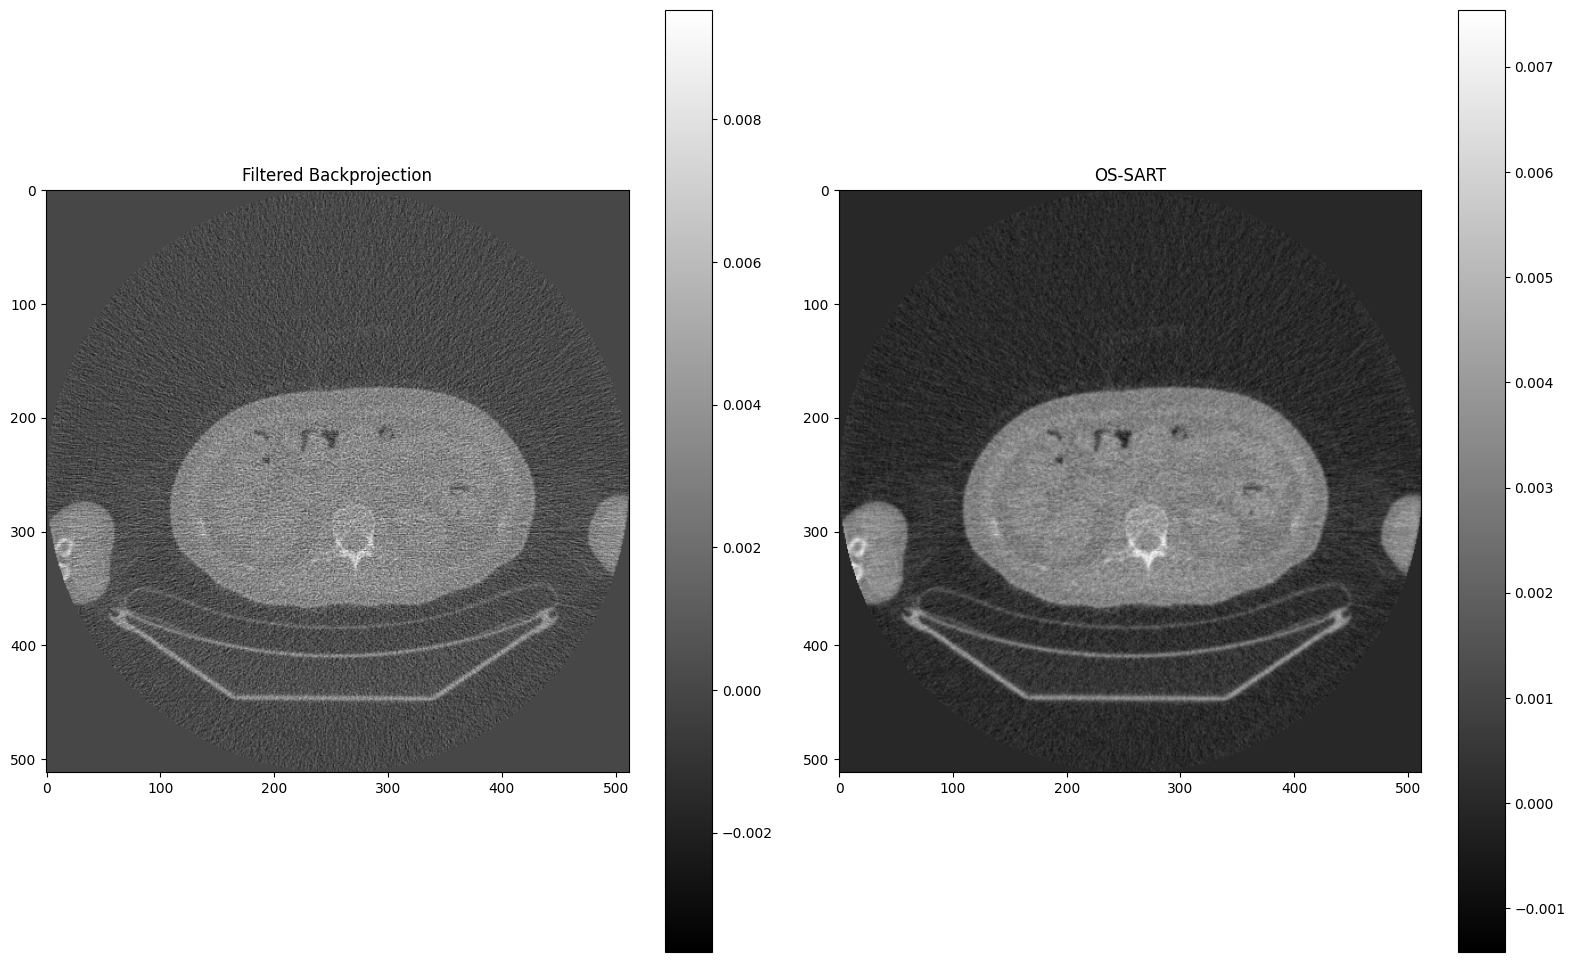

In [8]:
# Number of subsets (dividing the sinogram angles into smaller groups)
n_subsets = 10
subset_As = np.array_split(np.arange(len(theta)), n_subsets)  # This outputs 10 arrays, each with 18 elements. eg. [0...17][18...35]...[162...179]

gamma = -0.001
max_iter = 30

# Initialize reconstructed image (x^k)
image = np.zeros((clean_ct.shape[0], clean_ct.shape[0]))  

start_SART = time.time()
for k in range(max_iter):
    for subset in subset_As:
        # Forward project image into sino (A_i * x^k), certain projections multiplied by current reconstructed image
        theta_subset = theta[subset]
        estimated_sinogram = radon(image, theta=theta_subset, circle=True)  

        # Sinogram errors (A_i * x^k - b)
        sinogram_error = estimated_sinogram - clean_ct[:, subset]

        # Error between the blank image and the real image (multiplied by A^T_i)
        backprojected_error = iradon(sinogram_error, theta=theta_subset, filter_name=None, circle=True)  

        # Update step
        update = gamma * backprojected_error  # Apply OS-SART update rule
        image += update  # Correct: Update `image` instead of `final_sart`
end_SART = time.time()

# Compare with FBP reconstruction
fig, ax = plt.subplots(1, 2, figsize=(16, 16))

im5 = ax[0].imshow(recon_ct, cmap='gray')  # FBP
ax[0].set_title('Filtered Backprojection', fontsize=12)
fig.colorbar(im5, ax=ax[0], shrink=0.6)

im6 = ax[1].imshow(image, cmap='gray')  
ax[1].set_title('OS-SART', fontsize=12)
fig.colorbar(im6, ax=ax[1], shrink=0.6)

plt.tight_layout()
plt.show()



How does it compare to SIRT? First I will try the same parameters for SIRT, such that gamma = 0.001 and max iteration = 30, to assess how results differ between SIRT and OS-SART when hyperparameters are kept the same.

SIRT:

In [9]:
gamma=0.001
max_iter=30
x = np.zeros((clean_ct.shape[0], clean_ct.shape[0]))  

start_SIRT = time.time()
for k in range(max_iter):
    residual = clean_ct-radon(x,theta)
    gradient = gamma*iradon(residual,theta,filter_name=None) 
    x = x + gradient

end_SIRT = time.time()

SIRT AND SARTCOMPARISON:

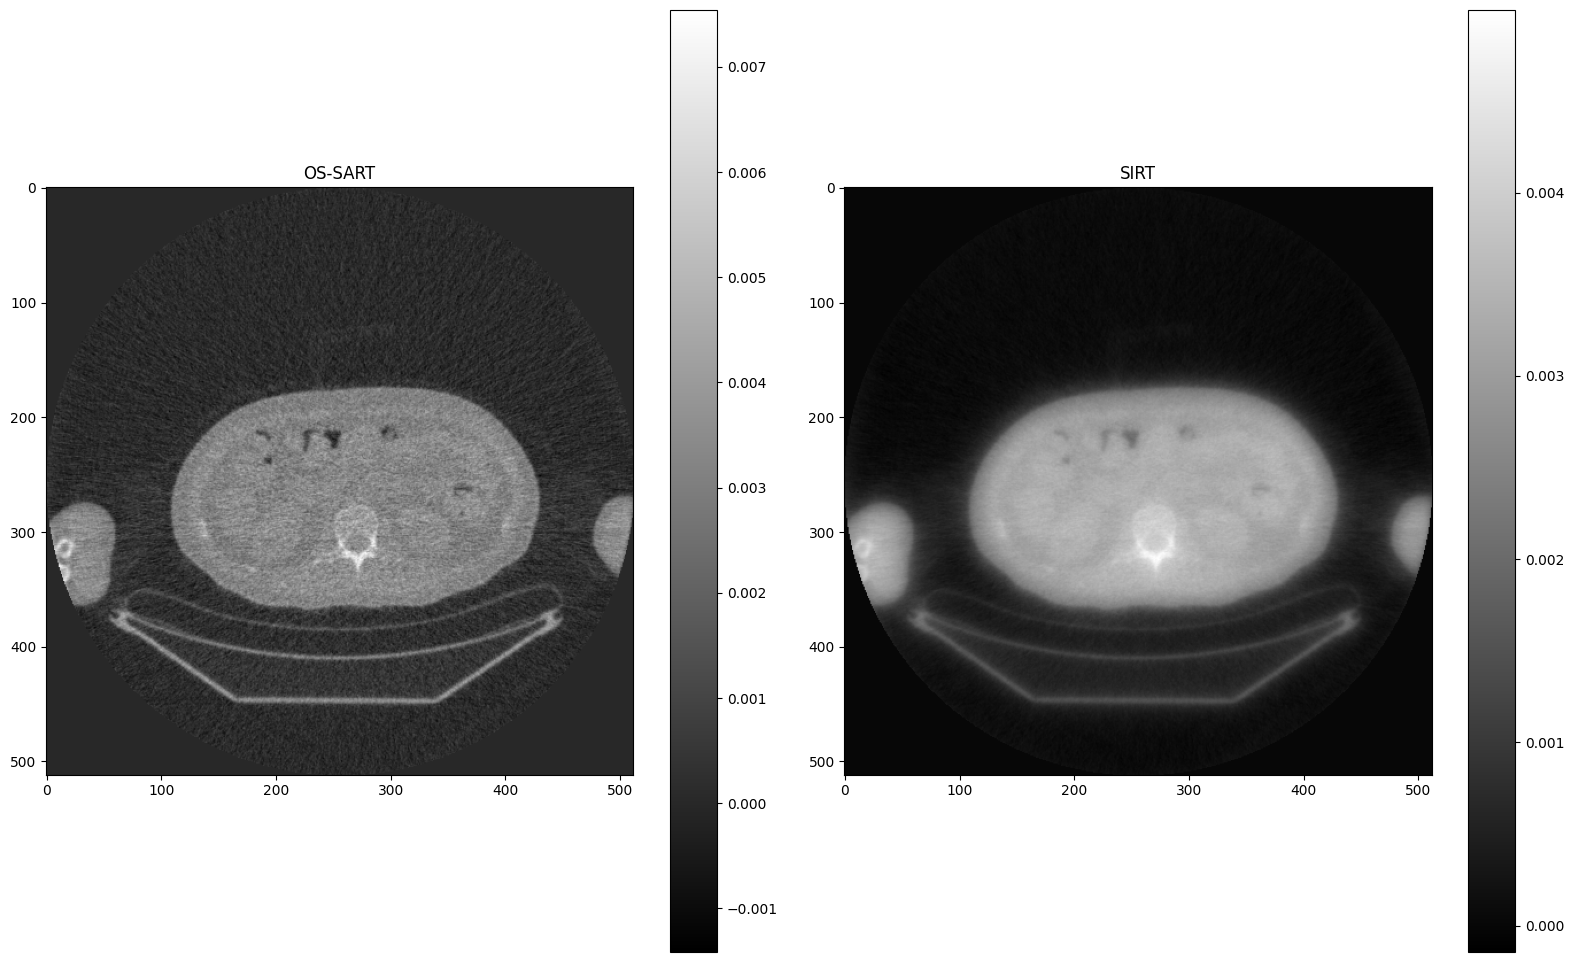

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(16, 16))

im7 = ax[0].imshow(image, cmap='gray')  # FBP
ax[0].set_title('OS-SART', fontsize=12)
fig.colorbar(im7, ax=ax[0], shrink=0.6)

im8 = ax[1].imshow(x, cmap='gray')  
ax[1].set_title('SIRT', fontsize=12)
fig.colorbar(im8, ax=ax[1], shrink=0.6)

plt.tight_layout()
plt.show()

How many more iterations of SIRT do I need to do, to get a comparable image? I will try iterations 60, 80, 100, 120. It seems that 100 did the best.

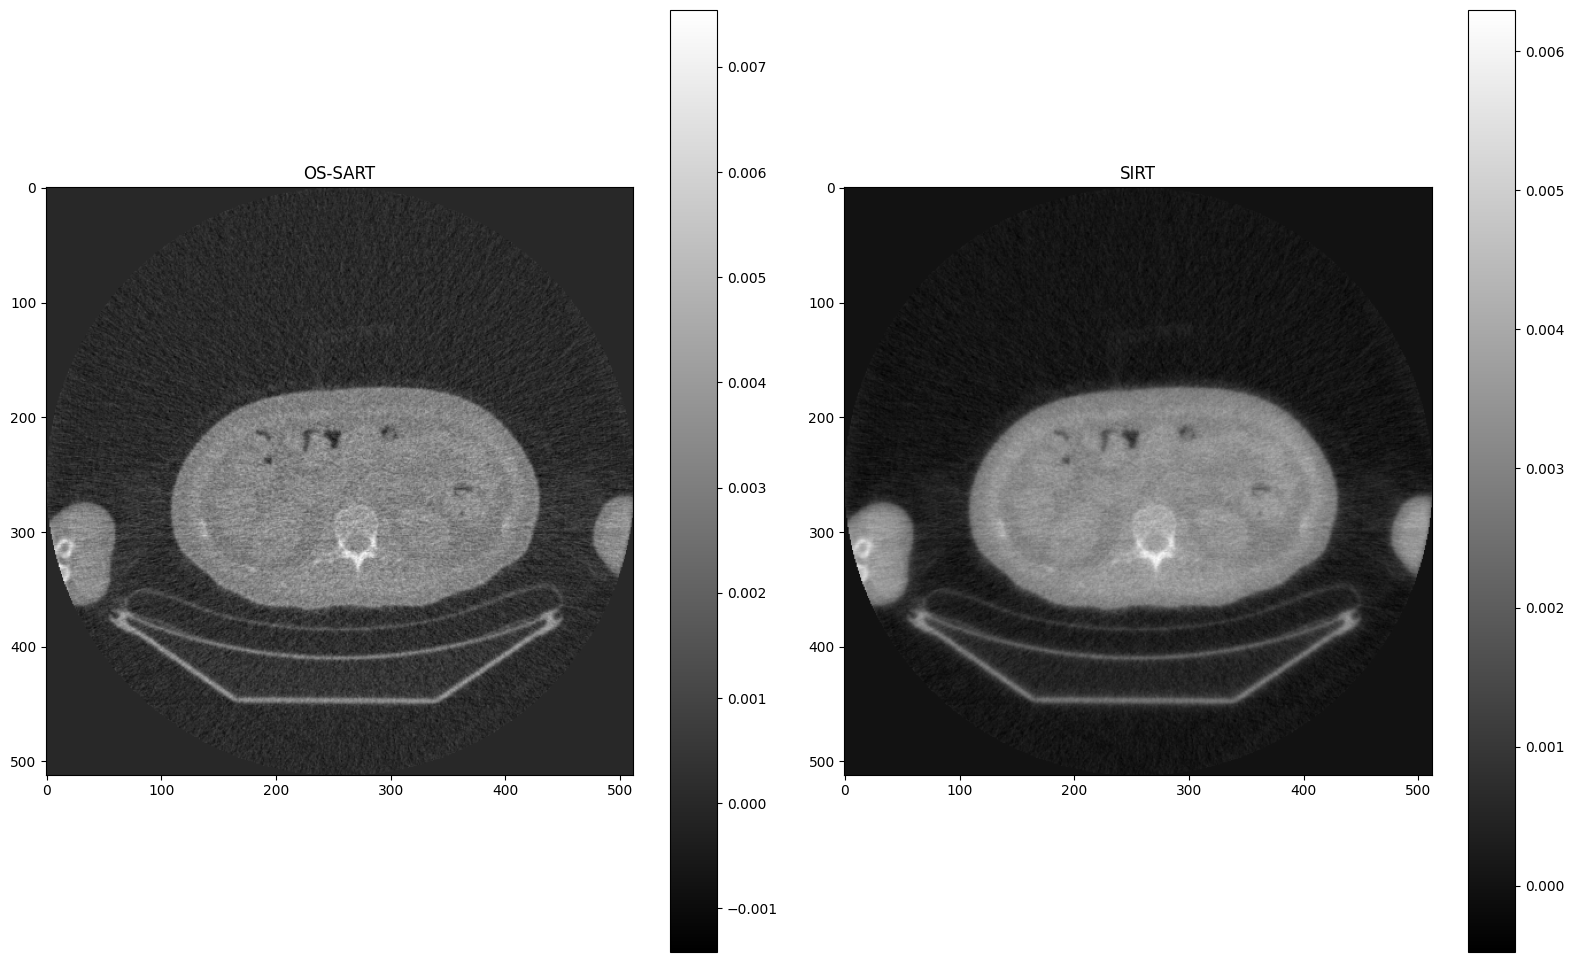

In [11]:
### SIRT, iteration 100

gamma=0.001
max_iter=100
x = np.zeros((clean_ct.shape[0], clean_ct.shape[0]))  

start_SIRT = time.time()
for k in range(max_iter):
    residual = clean_ct-radon(x,theta)
    gradient = gamma*iradon(residual,theta,filter_name=None) 
    x = x + gradient

end_SIRT = time.time()

# Plotting comparison
fig, ax = plt.subplots(1, 2, figsize=(16, 16))

im7 = ax[0].imshow(image, cmap='gray')  # FBP
ax[0].set_title('OS-SART', fontsize=12)
fig.colorbar(im7, ax=ax[0], shrink=0.6)

im8 = ax[1].imshow(x, cmap='gray')  
ax[1].set_title('SIRT', fontsize=12)
fig.colorbar(im8, ax=ax[1], shrink=0.6)

plt.tight_layout()
plt.show()

In [12]:
#SIRT needed more iterations to  converge to a good picture, 100 iterations compared to 30 iterations from SART
### Comparing SIRT and OS-SART Time taken

print('Time taken for SIRT:', end_SIRT - start_SIRT)
print('Time taken for OS-SART:', end_SART - start_SART)


Time taken for SIRT: 221.01380610466003
Time taken for OS-SART: 72.75270390510559


### Ex1.3: Resizing
The PET image, at reconstruction, has pixels of 4.24 mm in size, and the CT image of 1.06 mm. I will first resize the CT reconstructed image, then forward project into a sinogram. Then using the CT sinogram, I will correct the cleaned PET sinogram. I will call this attn_corrected_PET.

/Users/Jasthecoolbean/Desktop/lent_coursework/medical_imaging/venv/lib/python3.9/site-packages/skimage/transform/radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(


Text(0.5, 1.0, 'CT corrected PET sinogram')

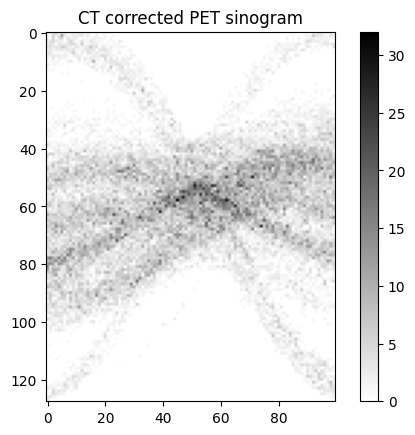

In [13]:
PET_pixel = 4.24 
CT_pixel = 1.06 

# Let's say your CT image has shape (H_ct, W_ct) #using OSART image
H_ct, W_ct = image.shape
scaling_factor = CT_pixel / PET_pixel  # 1.06 / 4.24 ≈ 0.25

# Compute new shape by scaling both dimensions
new_shape = (int(H_ct * scaling_factor), int(W_ct * scaling_factor))

# Resize with the correct shape
CT_rescale = resize(image, new_shape, anti_aliasing=True, preserve_range=True)

#forward propagate (image to sinogram)
theta = np.linspace(0., 180., 100, endpoint=False)
CT_forward = radon(CT_rescale,theta=theta)

# The attenuation formula is I_attenuated = I_0 * exp(- sum (mu * x) )
# the sum (mu * x) is essentially the sinogram 
# while I_attenuated is the PET image.
attn_corrected_PET = clean_pet / np.exp(-CT_forward) 
plt.imshow(attn_corrected_PET,cmap="gray_r") #reverse for PET
colorbar=plt.colorbar()
plt.title("CT corrected PET sinogram")


### Ex 1.4: PET reconstruction with FBP and OSEM

I will first test out OSEM with gamma = 0.001 and max_iteration = 20.

In [14]:

n_subsets = 10
subset_pet = np.array_split(np.arange(len(theta)), n_subsets)

gamma=0.001 
max_iter=20
osem = np.ones((attn_corrected_PET.shape[0], attn_corrected_PET.shape[0]))  

start_osem = time.time()

for k in range(max_iter):
    for subset in subset_pet:
        theta_subset = theta[subset]
        
        #forward project osem
        est_pet_sinogram = radon(osem, theta=theta_subset)
        
        #error in sinogram
        error = attn_corrected_PET[:,subset] / (est_pet_sinogram + 1e-6)
        
        #backprop
        backprojected_error = iradon(error, theta=theta_subset, filter_name=None, circle=True)  
        
        #update
        osem *= backprojected_error #np.zeros still won't work because there is a multiplicative operation here.

end_osem = time.time()



#osem uses 20 iterations here.

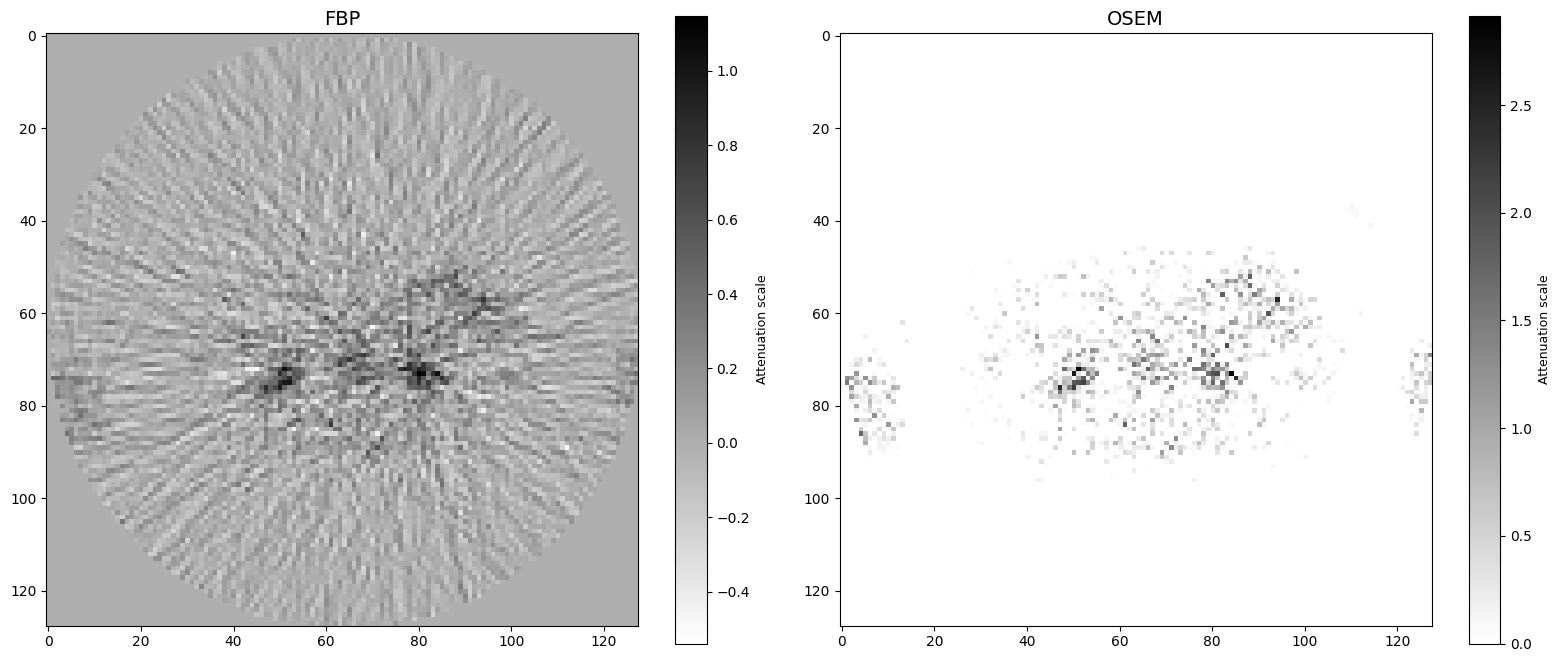

In [15]:
PET_fbp=iradon(attn_corrected_PET,theta=theta)

fig, ax = plt.subplots(1, 2, figsize=(16, 16))

im1 = ax[0].imshow(PET_fbp, cmap="gray_r")
ax[0].set_title("FBP", fontsize=14)
bar1=fig.colorbar(im1, ax=ax[0],shrink=0.4)
bar1.set_label("Attenuation scale",fontsize=9)

im2 = ax[1].imshow(osem, cmap="gray_r")
ax[1].set_title("OSEM", fontsize=14)
bar2=fig.colorbar(im2, ax=ax[1],shrink=0.4)
bar2.set_label("Attenuation scale",fontsize=9)

plt.tight_layout()
plt.show()

How does this compare to MLEM (some information about MLEM: https://web.stanford.edu/~pratx/PDF/DMLEM.pdf). Essentially MLEM is using the full dataset, while OSEM uses batches.

In [16]:
gamma=0.001 
max_iter=20
mlem = np.ones((attn_corrected_PET.shape[0], attn_corrected_PET.shape[0]))  

start_mlem = time.time()

for k in range(max_iter):
    
    #forward project osem
    est_pet_sinogram = radon(mlem, theta=theta)
    
    #error in sinogram
    error = attn_corrected_PET / (est_pet_sinogram + 1e-6) #i_0 is the measured PET sinogram, also known as b. est_pet_sinogram is the estimated one, also Ai * x^k (forward projected from empty image)
    
    #backprop
    backprop = iradon(error, theta=theta, filter_name=None, circle=True)  
    
    #normalisation (A^T(1)), a matrix of 1s with the same size as my PET measured sinogram. then tranposed, or backpropagated.
    normalisation = iradon(np.ones_like(attn_corrected_PET), theta=theta, filter_name=None, circle=True)
    
    mlem = (mlem / (normalisation + 1e-6)) * backprop 

end_mlem = time.time()



Comparing OSEM and MLEM side by side, I see OSEM outperforms MLEM.

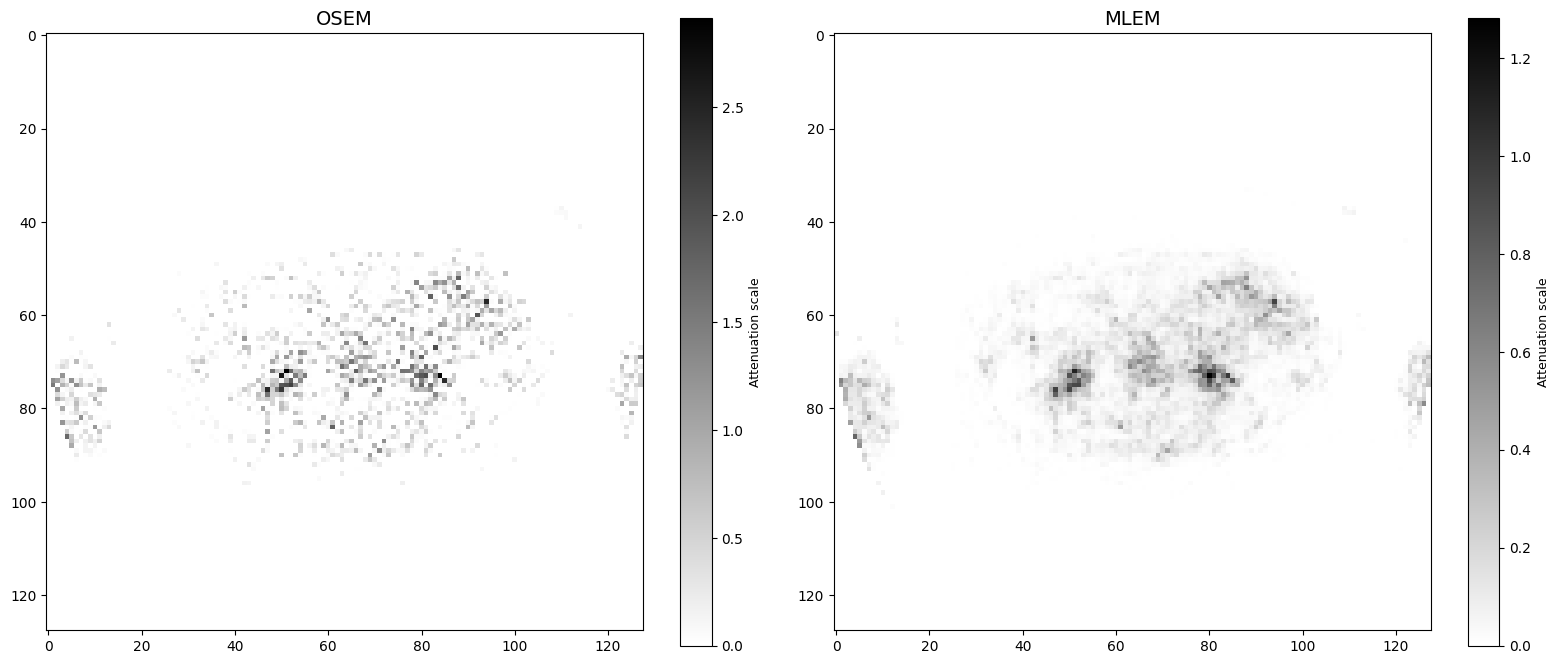

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(16, 16))

im1 = ax[0].imshow(osem, cmap="gray_r")
ax[0].set_title("OSEM", fontsize=14)
bar1=fig.colorbar(im1, ax=ax[0],shrink=0.4)
bar1.set_label("Attenuation scale",fontsize=9)

im2 = ax[1].imshow(mlem, cmap="gray_r")
ax[1].set_title("MLEM", fontsize=14)
bar2=fig.colorbar(im2, ax=ax[1],shrink=0.4)
bar2.set_label("Attenuation scale",fontsize=9)

plt.tight_layout()
plt.show()

In [18]:
print(f"Time taken for OSEM in 20 iterations: {end_osem - start_osem}")
print(f"Time taken for MLEM in 20 iterations: {end_mlem- start_mlem}")

Time taken for OSEM in 20 iterations: 2.556030035018921
Time taken for MLEM in 20 iterations: 2.426011085510254


How many more iterations of MLEM do I need to do to get as good of a result as OSEM? Let me try 50 iterations, and time it.

In [19]:
gamma=0.001 
max_iter=50
mlem_50it = np.ones((attn_corrected_PET.shape[0], attn_corrected_PET.shape[0]))  

start_mlem_50it = time.time()

for k in range(max_iter):
    
    #forward project melem
    est_pet_sinogram = radon(mlem_50it, theta=theta)
    
    #error in sinogram
    error = attn_corrected_PET / (est_pet_sinogram + 1e-6) #i_0 is the measured PET sinogram, also known as b. est_pet_sinogram is the estimated one, also Ai * x^k (forward projected from empty image)
    
    #backprop
    backprop = iradon(error, theta=theta, filter_name=None, circle=True)  
    
    #normalisation (A^T(1)), a matrix of 1s with the same size as my PET measured sinogram. then tranposed, or backpropagated.
    normalisation = iradon(np.ones_like(attn_corrected_PET), theta=theta, filter_name=None, circle=True)
    
    mlem_50it = (mlem_50it / (normalisation + 1e-6)) * backprop 

end_mlem_50it = time.time()


In [20]:
gamma=0.001 
max_iter=200
mlem_200it = np.ones((attn_corrected_PET.shape[0], attn_corrected_PET.shape[0]))  

start_mlem_200it = time.time()

for k in range(max_iter):
    
    #forward project melem
    est_pet_sinogram = radon(mlem_200it, theta=theta)
    
    #error in sinogram
    error = attn_corrected_PET / (est_pet_sinogram + 1e-6) #i_0 is the measured PET sinogram, also known as b. est_pet_sinogram is the estimated one, also Ai * x^k (forward projected from empty image)
    
    #backprop
    backprop = iradon(error, theta=theta, filter_name=None, circle=True)  
    
    #normalisation (A^T(1)), a matrix of 1s with the same size as my PET measured sinogram. then tranposed, or backpropagated.
    normalisation = iradon(np.ones_like(attn_corrected_PET), theta=theta, filter_name=None, circle=True)
    
    mlem_200it = (mlem_50it / (normalisation + 1e-6)) * backprop 

end_mlem_200it = time.time()

Text(0.5, 1.0, 'MLEM (200 iterations)')

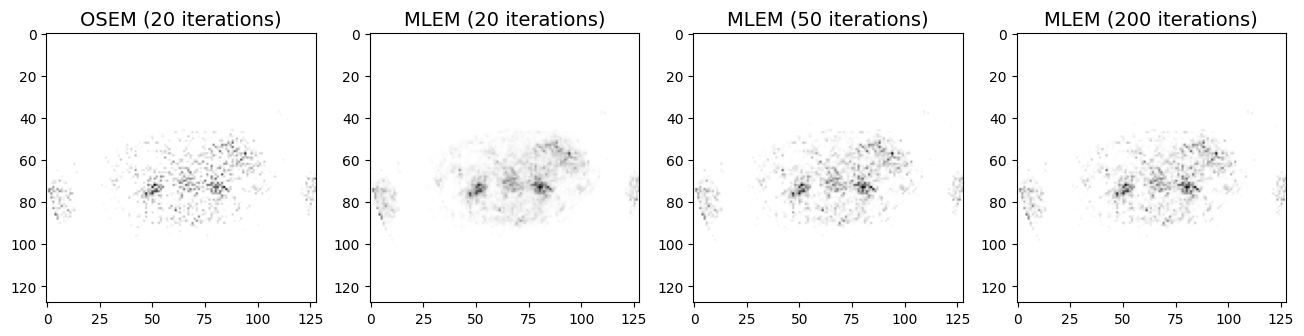

In [21]:
fig, ax = plt.subplots(1, 4, figsize=(16, 16))

ax[0].imshow(osem, cmap="gray_r")
ax[0].set_title("OSEM (20 iterations)", fontsize=14)
ax[1].imshow(mlem, cmap="gray_r")
ax[1].set_title("MLEM (20 iterations)", fontsize=14)
ax[2].imshow(mlem_50it, cmap="gray_r")
ax[2].set_title("MLEM (50 iterations)", fontsize=14)
ax[3].imshow(mlem_200it, cmap="gray_r")
ax[3].set_title("MLEM (200 iterations)", fontsize=14)

In [22]:
print(f"Time taken for OSEM in 20 iterations: {end_osem - start_osem}")
print(f"Time taken for MLEM in 20 iterations: {end_mlem- start_mlem}")
print(f"Time taken for MLEM in 50 iterations: {end_mlem_50it- start_mlem_50it}")
print(f"Time taken for MLEM in 200 iterations: {end_mlem_200it- start_mlem_200it}")

Time taken for OSEM in 20 iterations: 2.556030035018921
Time taken for MLEM in 20 iterations: 2.426011085510254
Time taken for MLEM in 50 iterations: 8.602141857147217
Time taken for MLEM in 200 iterations: 23.629859924316406


We see that if I run a FULL osem (no subsets), I will get the exact outcome as MLEM. I will try on 20 iterations:

In [23]:
gamma=0.001 
max_iter=20
osem_full = np.ones((attn_corrected_PET.shape[0], attn_corrected_PET.shape[0]))  

start_osem_full = time.time()

for k in range(max_iter):
        
    #forward project osem
    est_pet_sinogram = radon(osem_full, theta=theta)
    
    #error in sinogram
    error = attn_corrected_PET/ (est_pet_sinogram + 1e-6)
    
    #backprop
    backprojected_error = iradon(error, theta=theta, filter_name=None, circle=True)  
    
    #update
    osem_full *= backprojected_error #np.zeros still won't work because there is a multiplicative operation here.

end_osem_full = time.time()

Time taken for OSEM in 20 iterations: 2.205634117126465
Time taken for MLEM in 20 iterations: 2.426011085510254


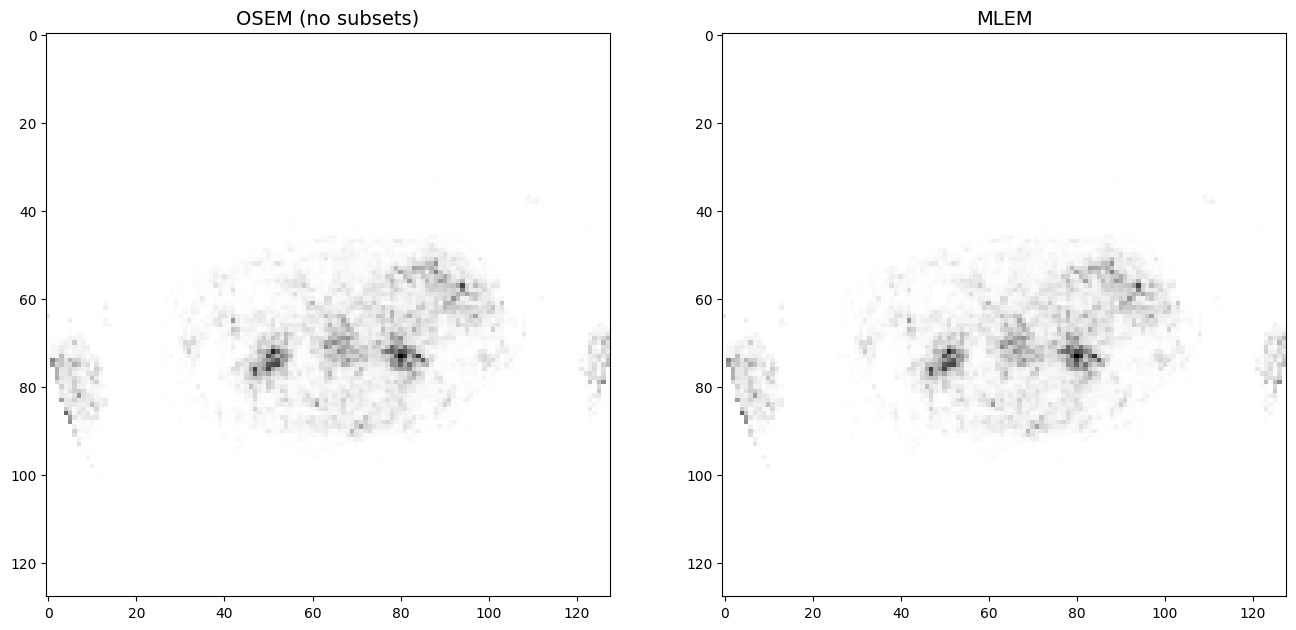

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(16, 16))

ax[0].imshow(osem_full, cmap="gray_r")
ax[0].set_title("OSEM (no subsets)", fontsize=14)
ax[1].imshow(mlem, cmap="gray_r")
ax[1].set_title("MLEM", fontsize=14)

print(f"Time taken for OSEM in 20 iterations: {end_osem_full - start_osem_full}")
print(f"Time taken for MLEM in 20 iterations: {end_mlem- start_mlem}")


I would like to overlay my OS-SART CT image with my OSEM PET image. Instead of downscaling the CT image (this will lose some important features),
I am upscaling my PET image. I am doing interpolation with openCV. inter_cubic method used, which is bicubic. (https://annmay10.medium.com/resizing-images-using-various-interpolation-techniques-4b99800999f2) bicubic usese a 4x4 neighbourhood. basically it is a sum of weight * the value of the pixel. (weight corresponds to how close the interpolated pixel is to the original pixel)

Text(0.5, 1.0, 'Overlaying CT and PET scan')

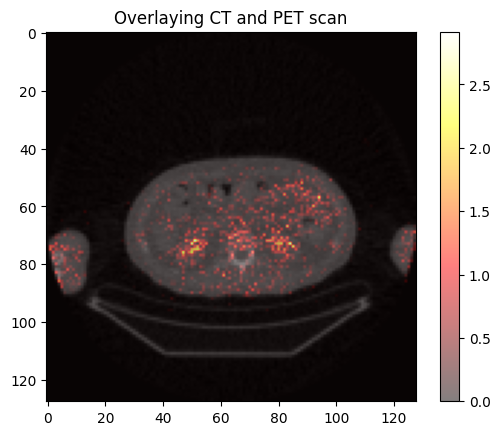

In [25]:
plt.imshow(CT_rescale, cmap="gray")
plt.imshow(osem, cmap="hot", alpha=0.5)
plt.colorbar()
plt.title("Overlaying CT and PET scan")